
I would like to share some helpful tools for designing and evaluating experiments. These tools provide a user-friendly method for estimating statistical power when dealing with multiple treatments or variants. Additionally, they assist with sample allocation, including determining sample size for both treatment and control groups. Lastly, they to estimate power assuming different expected effects (e.g., minimum detectable effects or MDE).

Calculating power for complex and uplift models using ML is a significantly difficult task. I will share some general guidelines and references at the conclusion of this post.or complex and uplift models using ML is far more challenging. At the end of this post, we provide some rules of thumb and references.


## Let's start with some terms

Each time we conduct a statistical test to estimate an effect, we can have any of these outcomes:

These errors and probabilities of success are related to some standard statistical terms we use when making inferences:

- **Type I Error ($\alpha$)**: the probability of rejecting the null hypothesis when it's true.
- **Type II Error ($\beta$)**: the probability of failing to reject the null hypothesis when it's false.
- **Power ($1-\beta$)**: the probability of rejecting the null hypothesis when it's false.
- **Confidence ($1-\alpha$)**: the probability of failing to reject the null hypothesis when it's true.

As a standard, $\alpha$ is set to 0.05 and power to .80. Also, we will generally have a control group (no intervention) and different treatments (variants). 


# There are some challenges

There are some challenges associated with basic power calculations (e.g., web calculators): 

- (Simultaneous) multiple comparisons
- Sample allocation
- Different MDEs by variant

In the case of multiple comparisons, conducting multiple statistical tests or comparisons within a study or analysis can inflate the likelihood of obtaining false positive results. We need then to adjust our $$\alpha$$ according to the different number of tests performed. In general, that will increase the sample size we need to reach a statistically significant result. We must consider this issue when designing our experiments, but also when analyzing ourt data (e.g., post hoc analyses).

To get a better intuition about why multiple comparison testing is an issue, let's simulate a simple example. Assume we have one control group, and three variants (treatments). For the sake of the example, we simulate data with no effect or differences between control and treatment groups. That is, the null hypothesis (i.e., no effect) is always true. For each iteration, we test the control group with each treatment and count if we get one or more significant results using $\alpha=0.05$. We know there is no differences between groups.

In [1]:
from scipy.stats import ttest_ind
import numpy as np
np.random.seed(0)

# Number of iterations for simulation
iterations = 1000

# Number of treatment groups
groups = 3

# Number of samples in each group
samples = 1000

# Count of batches where at least one false positive (Type I error) occurs
batches_with_errors = 0

# perform iterations
for _ in range(iterations):
    # Control group data
    control_group = np.random.normal(0, 1, samples)

    # Treatment group data - no actual difference from control
    treatment_groups = [np.random.normal(0, 1, samples) for _ in range(groups)]

    # A flag for any error within this batch of tests
    error_in_batch = False

    # perform t-test for each treatment group compared to control group
    for treatment in treatment_groups:
        t_stat, p_value = ttest_ind(control_group, treatment)

        # Check if p-value is less than 0.05 (significance level)
        if p_value < 0.05:
            error_in_batch = True
            break  # no need to check remaining tests

    if error_in_batch:
        batches_with_errors += 1

print(f"Probability of at least one Type I error in a batch of {groups} tests: {batches_with_errors / iterations * 100}%")

Probability of at least one Type I error in a batch of 3 tests: 12.6%


After 1000 iterations, **the probability of at least one Type I error in a batch of 3 tests is 12.6%**. This probability is also known as **Family-wise Error Rate (FWER)** and represents the probability of making at least one **Type I error** among the entire family (or batch) of comparisons. We can see that 12.6% is far from the alpha of 5% we assume for a single test. This is the **crux of the multiple comparison problem**. When you have a batch of tests, even maintaining an alpha around 0.05 in a single test, the chance of having at least one false discovery across the collection of tests is much higher and increases as the number of tests in a batch increases. That means some of our significant results can be false positives and hard to replicate when we run multiple comparisons!

The key to any adjustment of multiple comparison testing is to find a balance between minimizing false positives (errors where you incorrectly reject the null hypothesis) and not overly reducing the power of your test (the ability to correctly reject the null hypothesis when it's false). Some methods, such as Bonferroni or Holm, try to minimize the FWER. Others, like Benjamini-Hochberg, minimize the **False Discovery Rate (FDR)** or the expected proportion of Type I errors among all declared significant hypotheses. The aim here is to reduce the ratio of Type I errors among significant results, but not necessarily seeking to eliminate all false discoveries like FWER methods do. FDR methods tend to provide higher statistical power and are less conservative.

Another aspect of experiment design is **sample allocation**. Sample allocation might be different by group (e.g., 50/50), which can impact the power of our tests. In some cases, we want to minimize the potentially disruptive impact of an intervention and minimize the sample size across variants. In other cases, we might want to reduce the control group size or allocate more units to each variant based on their MDE. 

Finally, a good rule to define the **minimum MDE** is using the smallest effect to justify an intervention. We can estimate an intervention's ROI (return on investment) and define the minimum change in a critical metric (e.g., conversion rate) to reach an acceptable profit. The minimum MDE doesn't have to be the same by variant, as intervention costs or campaigns might differ. 

## Tools can help

We created some simple simulation methods in Python to design and assess the experimental data. We use simulation because it's simpler to accommodate different scenarios and metrics.  The downside is that it requires more computer power, but we can live with that :smile:. [You can find the power class here](https://github.com/sdaza/sdaza.github.io/tree/main/_jupyter).

These methods are helpful, especially with multiple variants, different allocations or MDE by group. As we will see, these methods only provide an estimate of power given a set of parameters, so we will need to do some grid search to assess multiple scenarios and find the optimal one. 

Let's start with a simple example using a proportion as the metric of interest:

In [2]:
from power_tools import * 

# load class
p = PowerSim(metric='proportion', relative_effect=False, variants=1, nsim=1000, alpha=0.05, alternative='two-tailed')

# get power
p.get_power(baseline=[0.33], effect=[0.03], sample_size=[3000])

,comparisons,power
0,"(0, 1)",0.706



`nsim` represents the number of simulations. Variants are set to 1, so we are only comparing control and treatment: `comparisons = (0,1)`. This example is too simple. Let's assume we have two variants (treatments): 


In [3]:
p = PowerSim(metric='proportion', relative_effect=False, variants=2, 
             nsim=1000, alpha=0.05, alternative='two-tailed')
p.get_power(baseline=[0.33], effect=[0.03], sample_size=[3000])

,comparisons,power
0,"(0, 1)",0.531
1,"(0, 2)",0.530
2,"(1, 2)",0.015


The function provides the power of all comparisons between groups with a sample size 3000 for each group. We can see a reduction in power due to multiple comparisons. As the effect of each variant is the same `(0.03)`, the comparison between variants 1 and 2 doesn't make sense here (in practice it will always be 0). We can define custom comparisons using a list of tuples. For instance, `comparisons=[(0,1), (0,2)]`:

In [4]:
p = PowerSim(metric='proportion', relative_effect=False, variants=2, 
             nsim=1000, alpha=0.05, alternative='two-tailed',
             comparisons=[(0,1), (0,2)])
p.get_power(baseline=[0.33], effect=[0.03], sample_size=[3000])

,comparisons,power
0,"(0, 1)",0.558
1,"(0, 2)",0.563



Only using two comparisons (each variant with a control), the power decreases considerably if we compare with the one-variant example.  For now, our function includes only three types of p-value corrections: `bonferroni` , `holm` and `fdr`. You can read more about them here, here, and here. In general, **Bonferroni** is more conservative, while **Holm** provides higher power. The `fdr` method minimizes the false discovery rate. This covers **Benjamini-Hochberg** for independent or positively correlated and **Benjamini-Yekutieli** for general or negatively correlated tests. When defining the power class, you can specify the parameter `fdr_method`. If `indep`, it implements **Benjamini-Hochberg**. If `negcorr`, **Benjamini-Yekutieli**.

The function will only correct for the comparisons defined in the parameter comparisons. When you run additional tests (e.g., comparing the performance of group A versus group B, or differences by demographic groups), you must make additional multiple comparison corrections in your analysis.

Back to our methods, we can add more variability into the experimental design and plot the expected power under different scenarios. To specify parameters, we need nested lists and use the method `grid_sim_power`. Things can become convoluted pretty fast.

The effect of the first and second variants over control varies: `[0.01, 0.03], [0.03, 0.05], [0.03, 0.07]``. Sample sizes are the same for each group, but they increase linearly. We use the `holm` correction. 

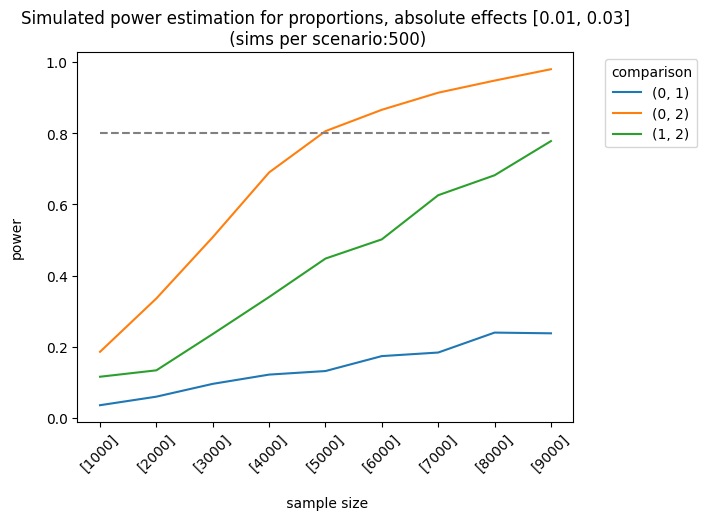

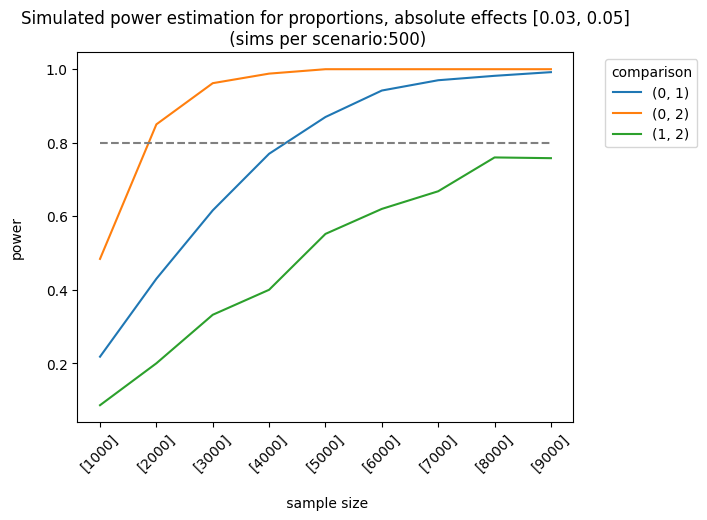

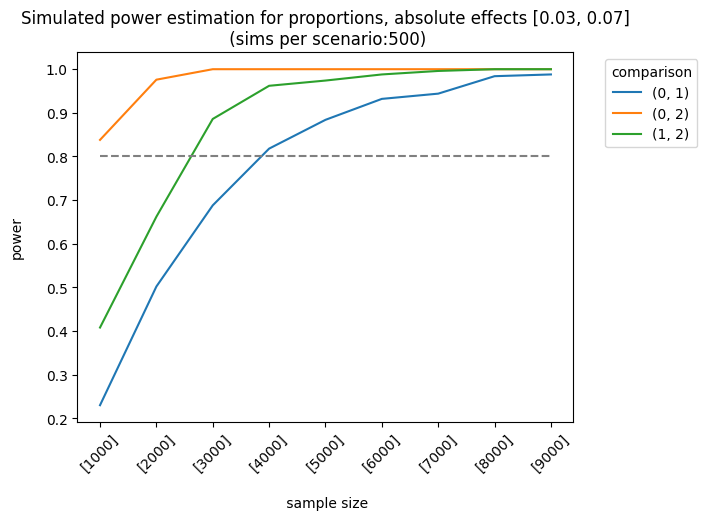

In [5]:
p = PowerSim(metric='proportion', relative_effect=False, variants=2, alternative='two-tailed', 
	nsim=500, correction='holm')
rr = p.grid_sim_power(baseline_rates=[[0.33]], 
                effects=[[0.01, 0.03], [0.03, 0.05], [0.03, 0.07]],
                sample_sizes= [[1000], [2000], [3000], [4000], [5000], [6000], [7000], [8000], [9000]], 
                threads=16, 
                plot=True)

As expected, the best scenario is when effect sizes are big enough to be detected.  We can also use different sample allocations and explore their consequences. You see that in the case of the effects `[0.03, 0.05]` , the allocation `[3000, 7000, 7000]` provides relatively good results.  


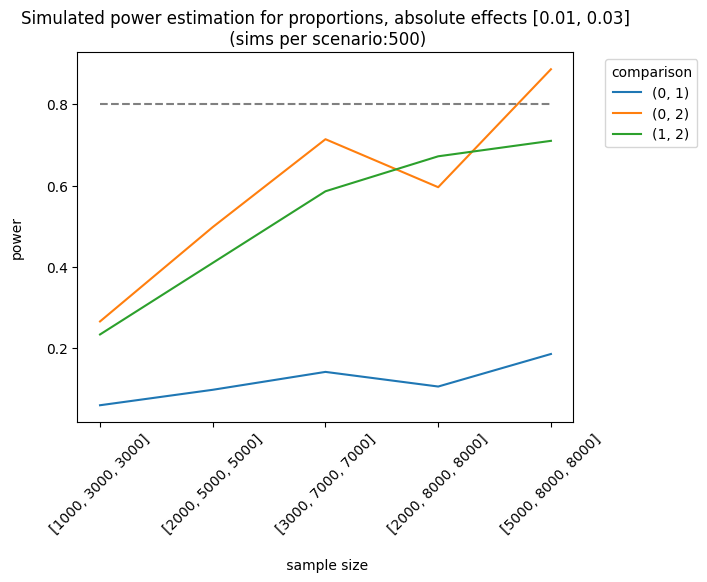

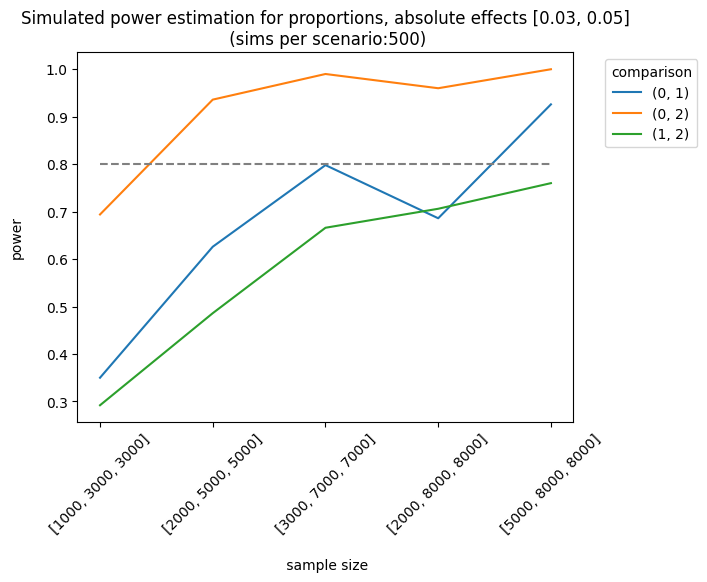

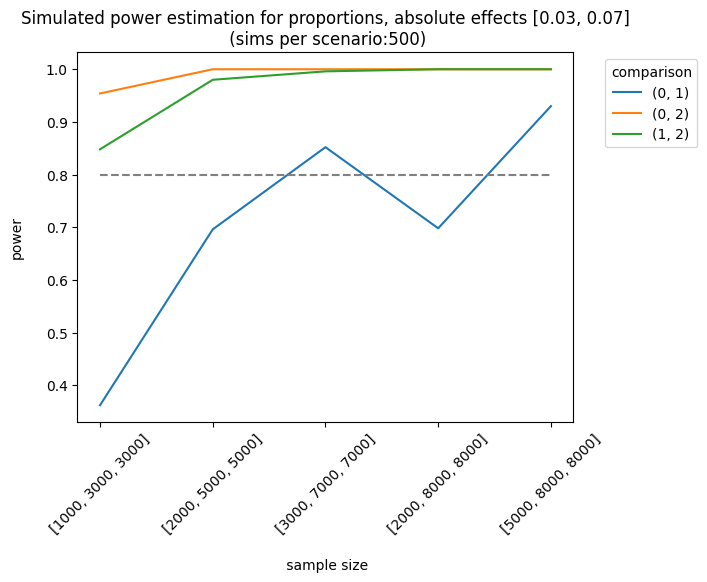

In [6]:
p = PowerSim(metric='proportion', relative_effect=False, variants=2, 
             alternative='two-tailed', nsim=500, correction='holm')
rr = p.grid_sim_power(baseline_rates=[[0.33]], 
                effects=[[0.01, 0.03], [0.03, 0.05], [0.03, 0.07]],
                sample_sizes= [[1000, 3000, 3000], 
                               [2000, 5000, 5000], 
                               [3000, 7000, 7000], 
                               [2000, 8000, 8000],
                               [5000, 8000, 8000]],
                threads=16, 
                plot=True)

We can also use other metrics (e.g., average or counts).  For instance, we can define an experiment for the number of visits (counts). The simulator will use a Poisson distribution where the only parameter, $\lambda$ (lambda), is the mean number of events. In this example, we set a baseline rate (lambda) of 1.2 visits and a relative increase of $0.05 (1.2*1.05) = 1.26$, with a control group of 3000 users and a treatment with 5000 users:

In [7]:
p = PowerSim(metric='count', relative_effect=True, variants=1, 
             alpha=0.05, alternative='two-tailed')
p.get_power(baseline=[1.2], effect=[0.05], sample_size=[3000, 5000])

,comparisons,power
0,"(0, 1)",0.69


The effect is small, so our test is underpowered (<0.80). We can also use averages (e.g., revenue), but in that case, we need to specify the standard deviation of the groups:


In [8]:
p = PowerSim(metric='average', relative_effect=False, variants=1, 
             alpha=0.05, alternative='two-tailed')
p.get_power(baseline=[1500], effect=[100], standard_deviation=[600], sample_size=[500])

,comparisons,power
0,"(0, 1)",0.81



# Complex models 

When using uplift or mixed models, things become more complicated. As Aleksander Molak put it: The question of defining a "safe" dataset size for S-Learner and other causal models is difficult to answer. Power calculations for machine learning models are often difficult, if possible at all. 

There are some tricks you can apply, though: If you can afford a pilot study or you have some historical data that represents a problem similar to the one that you’re interested in, you can find a subgroup in your data that is as homogenous as possible. You can estimate the sample size for this group using some of the traditional statistical power tools. Finally, scale your overall sample size so that this subgroup is properly powered relative to the entire sample (Harrell, 2023).

There are also some traditional ways to optimize the power of our tests:

- Blocking design
- Stratification and covariate adjustments (regression)

For instance, after learning from our uplift models, we can identify the key features defining users' responses to intervention. We can use those features to design our experiments (blocking). We can also evaluate the results of our uplift models in a new sample, and see if we can replicate the expected `uplift`.

# References

- Molak, Aleksander. Causal Inference and Discovery in Python: Unlock the secrets of modern causal machine learning with DoWhy, EconML, PyTorch and more . 
- https://www.fharrell.com/
- Ron Kohavi. Trustworthy Online Controlled Experiments.











